# Combining Naive Bayes and Logistic Regression on Toxic dataset

Steps:

1. Construct n-gram matrix using CountVectorizer(tokenizer = tokenize) (try ngram_range(1,3),max_features ~ 800k)
<br> or n-gram Tfidf

2. Naive Bayes

3. Use Fast.ai library for this task

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
from matplotlib import patches, patheffects
from fastai.dataset import *
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
test_df = pd.read_csv(PATH/'test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
PATH = Path('data/toxic')
df = pd.read_csv(PATH/'train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
labels=df.columns[2:].values

In [6]:
def trn_val_idxs(n,val_size=.2):
    np.random.seed(42)
    idx = np.random.permutation(n)
    val_idx = idx[:int(n*val_size)]
    trn_idx = idx[int(n*val_size):]
    return trn_idx,val_idx

In [8]:
trn_idx,val_idx = trn_val_idxs(df.shape[0])

In [9]:
train_df,val_df = df.iloc[trn_idx],df.iloc[val_idx]

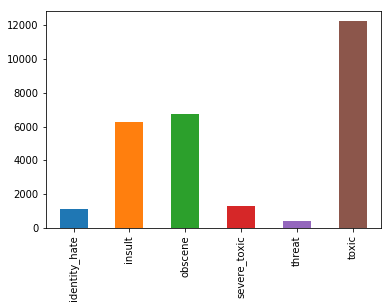

In [24]:
# Quick look at class distribution in train and val set
temp={}
for i in labels:
    temp[i]= train_df[i].value_counts()[1]
pd.Series(temp).plot(kind='bar')

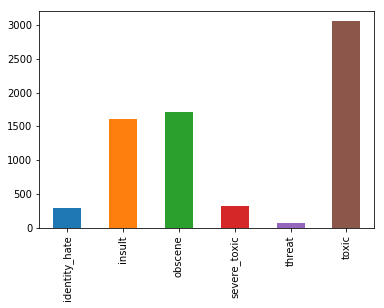

In [23]:
temp={}
for i in labels:
    temp[i]= val_df[i].value_counts()[1]
pd.Series(temp).plot(kind='bar')

In [10]:
# tokenize function
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# CountVectorizer

In [11]:
vec = CountVectorizer(tokenizer=tokenize,ngram_range=(1,3), max_features = 500000)
trn_bag = vec.fit_transform(train_df.comment_text)
val_bag = vec.transform(val_df.comment_text)

In [12]:
trn_bag.shape
val_bag.shape

(127657, 800000)

(31914, 800000)

# Naive Bayes

In [14]:
def pr(x,y,y_i):
    # get P(token i | label y_i)
    p = x[y==y_i]
    return (p.sum(0)+1) / (p.shape[0]+1)

In [20]:
vec = CountVectorizer(tokenizer=tokenize,ngram_range=(1,2), max_features = 100000)
trn_bag = vec.fit_transform(train_df.comment_text)
val_bag = vec.transform(val_df.comment_text)
x=trn_bag
# Accuracy for each labels
for label in labels:
    y = train_df[label].values
    r = np.log(pr(x,y,1) / pr(x,y,0))
    b = np.log((y==1).mean() / (y==0).mean())
    val_preds= val_bag @ r.T + b
    val_preds = val_preds > 0
    
#     trn_preds= x @ r.T + b
#     trn_preds = trn_preds > 0
    
    y_val = val_df[label].values
    print(f'{label} val acc: {(val_preds == y_val).mean():0.5f}')

toxic val acc: 0.83670
severe_toxic val acc: 0.90852
obscene val acc: 0.89033
threat val acc: 0.75765
insult val acc: 0.89667
identity_hate val acc: 0.92789


Tuning hyperparam

In [25]:
vec = CountVectorizer(tokenizer=tokenize,ngram_range=(1,2), max_features = 10000)
trn_bag = vec.fit_transform(train_df.comment_text)
val_bag = vec.transform(val_df.comment_text)
x=trn_bag
# Accuracy for each labels
for label in labels:
    y = train_df[label].values
    r = np.log(pr(x,y,1) / pr(x,y,0))
    b = np.log((y==1).mean() / (y==0).mean())
    val_preds= val_bag @ r.T + b
    val_preds = val_preds > 0
    
#     trn_preds= x @ r.T + b
#     trn_preds = trn_preds > 0
    
    y_val = val_df[label].values
    print(f'{label} val acc: {(val_preds == y_val).mean():0.5f}')

toxic val acc: 0.85239
severe_toxic val acc: 0.94118
obscene val acc: 0.90529
threat val acc: 0.95202
insult val acc: 0.91143
identity_hate val acc: 0.96837


In [68]:
# test set, test submission
def test_nb_submission(df,max_features):

    
    vec = CountVectorizer(tokenizer=tokenize,ngram_range=(1,2), max_features = max_features)
    trn_bag = vec.fit_transform(df.comment_text)
    x = trn_bag
    
    test_df = pd.read_csv(PATH/'test.csv')
    sub = pd.DataFrame(test_df.id.copy())
    
    test_bag = vec.transform(test_df.comment_text)

    # Accuracy for each labels
    for label in labels:
        y = df[label].values
        r = np.log(pr(x,y,1) / pr(x,y,0))
        b = np.log((y==1).mean() / (y==0).mean())
        
        preds= np.exp(test_bag @ r.T + b)
        # get prob of class 1
        preds = preds / (1 + preds)
        sub[label] = preds
    return sub
        
        

In [69]:
sub = test_nb_submission(df,500000)
sub.fillna(0,inplace=True)
sub.to_csv(PATH / 'submission/sub1.csv',index=False)

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


# Metric

# NB + BoW + Logistic Regression

# TfIdf + Logistic Regression